In [9]:
import numpy as np
from tqdm import tqdm
from data import Catalogue

In [2]:
base_names_0 = []
for i in range(10):
    cat = Catalogue.from_file(f'E:/new_dset_0/cat_{i:02d}.lat', 0)
    print(cat)
    base_names_0.extend(['_'.join(name.split('_')[:3]) for name in cat.names])

base_names_1 = []
for i in range(10):
    cat = Catalogue.from_file(f'E:/new_dset_1/cat_{i:02d}.lat', 0)
    print(cat)
    base_names_1.extend(['_'.join(name.split('_')[:3]) for name in cat.names])

# find set intersection
base_names_0 = set(base_names_0)
base_names_1 = set(base_names_1)
base_names = base_names_0.intersection(base_names_1)
print(f'Number of base names: {len(base_names)}')

Unit cell catalogue with 67238 entries
Unit cell catalogue with 69793 entries
Unit cell catalogue with 69510 entries
Unit cell catalogue with 68729 entries
Unit cell catalogue with 67450 entries
Unit cell catalogue with 68799 entries
Unit cell catalogue with 67876 entries
Unit cell catalogue with 68799 entries
Unit cell catalogue with 69225 entries
Unit cell catalogue with 68161 entries
Unit cell catalogue with 67238 entries
Unit cell catalogue with 69367 entries
Unit cell catalogue with 70007 entries
Unit cell catalogue with 67735 entries
Unit cell catalogue with 68231 entries
Unit cell catalogue with 68799 entries
Unit cell catalogue with 67450 entries
Unit cell catalogue with 67592 entries
Unit cell catalogue with 70077 entries
Unit cell catalogue with 68161 entries
Number of base names: 9041


In [6]:
# load the compliance tensors from both datasets and make sure that they match
# for the lattices without imperfections
# load only the intersecting base lattices and only zero imperfections
cat_0_lines = dict()
for i in range(10):
    cat = Catalogue.from_file(f'E:/new_dset_0/cat_{i:02d}.lat', 0)
    cat_lines = cat.lines
    # keep only the base lattices that are in the intersection
    cat_lines = {name:line for name, line in cat_lines.items() if ('_'.join(name.split('_')[:3]) in base_names) and (float(name.split('_')[4]) == 0.0)}
    cat_0_lines.update(cat_lines)
    print(cat, ' -> ', len(cat_0_lines))

cat_1_lines = dict()
for i in range(10):
    cat = Catalogue.from_file(f'E:/new_dset_1/cat_{i:02d}.lat', 0)
    cat_lines = cat.lines
    # keep only the base lattices that are in the intersection
    cat_lines = {name:line for name, line in cat_lines.items() if ('_'.join(name.split('_')[:3]) in base_names) and (float(name.split('_')[4]) == 0.0)}
    cat_1_lines.update(cat_lines)
    print(cat, ' -> ', len(cat_1_lines))


Unit cell catalogue with 67238 entries  ->  879
Unit cell catalogue with 69793 entries  ->  1791
Unit cell catalogue with 69510 entries  ->  2710
Unit cell catalogue with 68729 entries  ->  3615
Unit cell catalogue with 67450 entries  ->  4515
Unit cell catalogue with 68799 entries  ->  5418
Unit cell catalogue with 67876 entries  ->  6313
Unit cell catalogue with 68799 entries  ->  7216
Unit cell catalogue with 69225 entries  ->  8142
Unit cell catalogue with 68161 entries  ->  9041
Unit cell catalogue with 67238 entries  ->  879
Unit cell catalogue with 69367 entries  ->  1791
Unit cell catalogue with 70007 entries  ->  2710
Unit cell catalogue with 67735 entries  ->  3615
Unit cell catalogue with 68231 entries  ->  4515
Unit cell catalogue with 68799 entries  ->  5418
Unit cell catalogue with 67450 entries  ->  6313
Unit cell catalogue with 67592 entries  ->  7216
Unit cell catalogue with 70077 entries  ->  8142
Unit cell catalogue with 68161 entries  ->  9041


In [7]:
# match lattice names to base names in both catalogues
bnames_0 = {}
for name in cat_0_lines:
    bname = '_'.join(name.split('_')[:3])
    imp_level = float(name.split('_')[4])
    if imp_level==0.0:
        bnames_0[bname] = name
bnames_1 = {}
for name in cat_1_lines:
    bname = '_'.join(name.split('_')[:3])
    imp_level = float(name.split('_')[4])
    if imp_level==0.0:
        bnames_1[bname] = name

cat_0 = Catalogue(cat_0_lines, 0)
cat_1 = Catalogue(cat_1_lines, 0)

In [39]:
compl_errors = {}
stiff_errors = {}
for bname in tqdm(base_names):
    assert bname in bnames_0, f'{bname} not in bnames_0'
    assert bname in bnames_1, f'{bname} not in bnames_1'    
    S0 = cat_0[bnames_0[bname]]['compliance_tensors']
    S1 = cat_1[bnames_1[bname]]['compliance_tensors']
    assert sorted(S0.keys()) == sorted(S1.keys()), f'{bname} has different relative densities'
    S0 = np.stack([S0[rel_dens] for rel_dens in sorted(S0.keys())], axis=0)
    S1 = np.stack([S1[rel_dens] for rel_dens in sorted(S1.keys())], axis=0)
    C0 = np.linalg.inv(S0)
    C1 = np.linalg.inv(S1)
    error_perc = np.abs(S0-S1)/np.max(S0, axis=(1,2), keepdims=True)*100
    compl_errors[bname] = error_perc.mean()
    error_perc = np.abs(C0-C1)/np.max(C0, axis=(1,2), keepdims=True)*100
    stiff_errors[bname] = error_perc.mean()

100%|██████████| 9041/9041 [00:15<00:00, 586.38it/s]


In [40]:
with np.printoptions(precision=3, suppress=True):
    print(bname)
    print('5% relative density')
    print(S0[-1])
    print(S1[-1])
    print('0.1% relative density')
    print(S0[0])
    print(S1[0])

tet_Z04.0_R154
5% relative density
[[1395.8   -849.71  -484.31     0.994   -1.841   -0.051]
 [-849.71  1397.6   -484.8      0.829    3.851    1.291]
 [-484.31  -484.8   1030.1     -0.996    0.48    -0.794]
 [   0.994    0.829   -0.996 2108.3     -0.336    1.382]
 [  -1.841    3.851    0.48    -0.336 2114.5      0.98 ]
 [  -0.051    1.291   -0.794    1.382    0.98  1138.2  ]]
[[1394.5   -848.29  -483.86    -0.148   -0.074   -1.724]
 [-848.29  1393.7   -483.82     1.16     0.159    1.752]
 [-483.86  -483.82  1029.6     -0.304   -0.215   -0.089]
 [  -0.148    1.16    -0.304 2106.5     -0.094    0.041]
 [  -0.074    0.159   -0.215   -0.094 2106.8      0.529]
 [  -1.724    1.752   -0.089    0.041    0.529 1137.3  ]]
0.1% relative density
[[ 3342200.   -2110200.   -1232400.      -1965.8       680.82      216.12]
 [-2110200.    3342500.   -1232500.        926.46    -1801.1       242.6 ]
 [-1232400.   -1232500.    2474900.        843.69      639.8      -720.31]
 [   -1965.8       926.46      8

In [41]:
with np.printoptions(precision=3, suppress=True):
    print(bname)
    print(S0[0])
    print(S1[0])
    print(error_perc[0])

tet_Z04.0_R154
[[ 3342200.   -2110200.   -1232400.      -1965.8       680.82      216.12]
 [-2110200.    3342500.   -1232500.        926.46    -1801.1       242.6 ]
 [-1232400.   -1232500.    2474900.        843.69      639.8      -720.31]
 [   -1965.8       926.46      843.69  4842800.       2977.5     -1720.3 ]
 [     680.82    -1801.1       639.8      2977.5   4842200.      -1886.5 ]
 [     216.12      242.6      -720.31    -1720.3     -1886.5   2577500.  ]]
[[ 3339900.   -2110500.   -1234100.      -3025.2      4396.8     -3562.3 ]
 [-2110500.    3346900.   -1232500.       -117.69    -2561.7      2234.2 ]
 [-1234100.   -1232500.    2476700.       -309.61      512.38     2036.  ]
 [   -3025.2      -117.69     -309.61  4839200.       2607.4     -1763.3 ]
 [    4396.8     -2561.7       512.38     2607.4   4849200.      -1628.8 ]
 [   -3562.3      2234.2      2036.      -1763.3     -1628.8   2582400.  ]]
[[1.358 1.202 1.271 0.068 0.059 0.037]
 [1.202 1.046 1.116 0.068 0.059 0.037]
 [1.2

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

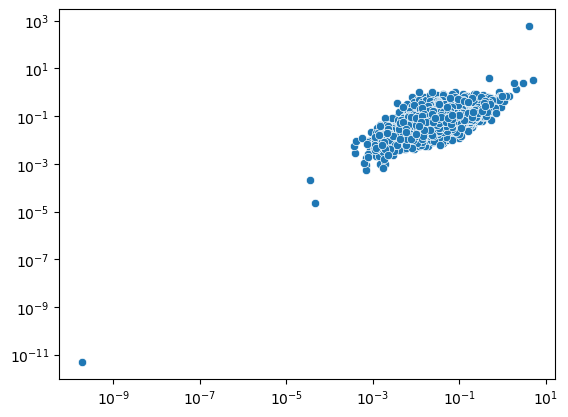

In [12]:
sns.scatterplot(x=compl_errors.values(), y=stiff_errors.values())
plt.xscale('log')
plt.yscale('log')
# somewhat, not super strong

In [ ]:
df = pd.DataFrame({'Compliance error': compl_errors.values(), 'Stiffness error': stiff_errors.values()}).melt()
sns.histplot(data=df, x='value', hue='variable', log_scale=True)
plt.show()

In [ ]:
sns.ecdfplot(data=df, x='value', hue='variable', log_scale=True)
plt.xlim(1e-3, 1e1)
plt.show()

In [ ]:
sorted_errors = sorted(compl_errors.items(), key=lambda x: x[1])
compl_names = [bname for bname, error in sorted_errors[:8200]]
sorted_errors = sorted(stiff_errors.items(), key=lambda x: x[1])
stiff_names = [bname for bname, error in sorted_errors[:8200]]
best_base_names = set(compl_names).intersection(stiff_names)
len(best_base_names)

In [ ]:
best_base_names = list(best_base_names)
# sort by lattice code
best_base_names.sort(key=lambda x: int(x.split('_')[2].lstrip('ER')))
with open('E:/best_base_names.txt', 'w') as fout:
    fout.write('\n'.join(best_base_names))